In [1]:
import pandas as pd
import numpy as np

import featuretools as ft

from woodwork.logical_types import Categorical, Boolean, Datetime, Double

# from featuretools_sklearn_transformer import DFSTransformer => did not work
from featuretools.selection import (
    remove_highly_correlated_features,
    remove_highly_null_features,
    remove_single_value_features,
)

from datetime import datetime
from uuid import uuid4
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
import xgboost as xgb

from scipy.stats import uniform, randint


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from typing import List, Any
from enum import Enum
from dataclasses import dataclass

pd.option_context("max_columns", None)

In [2]:
# https://github.com/IBM/telco-customer-churn-on-icp4d
URL_TO_DATA = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"


BACK_COUNT_DATE = datetime.fromisoformat("2022-01-01")
TEST_SIZE = 0.2
VALID_SIZE = 0.25
RANDOM_STATE = 42
NUMERIC_TRANSFORMER_REPLACEMENT = "median"

In [3]:
# fmt:off
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(missing_values=np.nan, strategy=NUMERIC_TRANSFORMER_REPLACEMENT)),
        ("scaler", StandardScaler()),
    ]
)
# fmt:on 

def get_cols_by_type(
    in_df: pd.DataFrame, types_to_search: list, exclude_ids: Boolean = True
) -> list:
    cols = in_df.select_dtypes(include=types_to_search).columns.to_list()

    if exclude_ids:
        return list(filter(lambda x: not x.endswith("ID"), cols))

    return cols

- ft titanic https://www.kaggle.com/code/liananapalkova/automated-feature-engineering-for-titanic-dataset/notebook
- the dataset https://github.com/IBM/telco-customer-churn-on-icp4d/blob/master/data/Telco-Customer-Churn.csv
- titanic https://medium.com/dataexplorations/tool-review-can-featuretools-simplify-the-process-of-feature-engineering-5d165100b0c3
- time indexing recomandations https://stackoverflow.com/questions/49711987/how-do-i-prevent-data-leakage-with-featuretools




### Denormalize into 
- customer_df:      customer_id (PK), subscription_id (FK), gender, SeniorCitizen, Partner, Dependents, tenure, Churn
- services_df:      service_id (PK), service_name
- subscription_df:  subscription_id (PK), service_id, customer_id
- billing_df:       billing_id, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges


In [4]:
# in case of CERTIFICATE_VERIFY_FAILED run Install Certificates.command
# see also https://stackoverflow.com/questions/50236117/scraping-ssl-certificate-verify-failed-error-for-http-en-wikipedia-org
df = pd.read_csv(filepath_or_buffer=URL_TO_DATA, index_col=0)

In [5]:
# convert
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# generate syntetic time index
df["ContractStartDate"] = list(
    map(
        lambda tenure, dat=BACK_COUNT_DATE: dat - relativedelta(months=-tenure),
        df["tenure"],
    )
)

# convert to categoric for pipline processing


df["customerID"] = df.index
df["billingID"] = [str(uuid4()) for _ in range(df.shape[0])]
df["subscriptionID"] = [str(uuid4()) for _ in range(df.shape[0])]

# convert to 1/0
df["Churn"] = np.where(df["Churn"] == "Yes", 1, 0)

In [6]:
# TODO: write nice dataclass to map featertools type, pandas and sklearn type
# add this info also

CUSTOMERS = {
    # "customerID",
    "gender":Boolean,
     "SeniorCitizen":Boolean,
    "Partner":Boolean,
    "Dependents":Boolean,
}


SUBSCRIPTIONS = {
    # "customerID",
    "PhoneService" :Categorical,
    "MultipleLines":Boolean,
    "InternetService":Categorical,
    "OnlineSecurity":Categorical,
    "OnlineBackup":Categorical,
    "DeviceProtection":Categorical,
    "TechSupport":Categorical,
    "StreamingTV":Categorical,
    "StreamingMovies":Categorical,
}


BILLINGS = {
    # "customerID",
    "tenure":Double,
    "Contract":Categorical,
    "PaperlessBilling":Boolean,
    "PaymentMethod":Categorical,
    "MonthlyCharges":Double,
    "TotalCharges":Double,
    # "Churn",
}




@dataclass
class EntitySetColumns:
    new_dataframe_name: str
    index: str
    additional_columns: list


entity_set_columns = {
    "customers": EntitySetColumns(
        index="customerID", new_dataframe_name=None, additional_columns=list(CUSTOMERS.keys())
    ),
    "subscriptions": EntitySetColumns(
        index="subscriptionID",
        new_dataframe_name="subscriptions",
        additional_columns=list(SUBSCRIPTIONS.keys()),
    ),
    "billings": EntitySetColumns(
        index="billingID", new_dataframe_name="billings", additional_columns=list(BILLINGS.keys())
    ),
}

In [7]:
y = df["Churn"]
X = df.drop(columns=["Churn"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=VALID_SIZE, random_state=RANDOM_STATE
)  # 0.25 x 0.8 = 0.2

In [8]:
def entityset_wrapper(
    id: str,
    data_frame_name: str, 
    feature_dataset: pd.DataFrame,
    variable_types: dict,
    entity_set_columns: dict,
) -> ft.EntitySet:
    """Non generic wrapper for making ft.EntitySet"""
    es = ft.EntitySet(id=id)

    es.add_dataframe(
        dataframe_name=data_frame_name,
        index=entity_set_columns.get("customers").index,
        logical_types=variable_types,
        dataframe=feature_dataset,
    )

    es.normalize_dataframe(
        base_dataframe_name=data_frame_name,
        new_dataframe_name=entity_set_columns.get("billings").new_dataframe_name,
        index=entity_set_columns.get("billings").index,
        additional_columns=entity_set_columns.get("billings").additional_columns,
    )

    es.normalize_dataframe(
        base_dataframe_name=data_frame_name,
        new_dataframe_name=entity_set_columns.get("subscriptions").new_dataframe_name,
        index=entity_set_columns.get("subscriptions").index,
        additional_columns=entity_set_columns.get("subscriptions").additional_columns,
    )

    return es

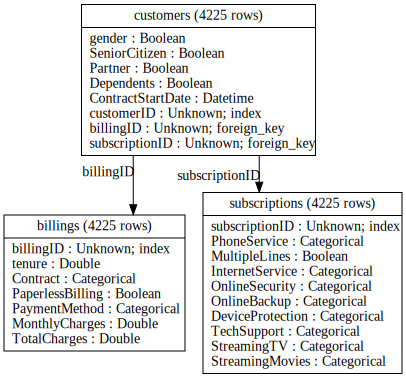

In [9]:
es = entityset_wrapper(
    id="customers_train",
    data_frame_name="customers",
    feature_dataset=X_train,
    variable_types=CUSTOMERS | SUBSCRIPTIONS | BILLINGS,
    entity_set_columns=entity_set_columns,
)
es.plot()

In [10]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="customers",
    max_depth=2,
    include_cutoff_time=False,
    agg_primitives=None,
    cutoff_time=None,
    instance_ids=None,
)

feature_matrix_enc, features_enc = ft.encode_features(feature_matrix, feature_defs)


In [11]:
# feature selection
#feature_selector = Pipeline(
#    steps=[
#        ("rm_highly_null_features",         FunctionTransformer(remove_highly_null_features)),
#        ("rm_single_value_features",        FunctionTransformer(remove_single_value_features)),
#    ]
#)

    #remove_highly_correlated_features,
    #remove_highly_null_features,
    #remove_single_value_features,

 #   set(features) - set(new_features)

# not necessary
#tmp, temp2  = remove_highly_null_features(feature_matrix_enc, features_enc, pct_null_threshold=.90)
#set(features_enc) - set(temp2)

#feature_matrix_enc_selected, features_enc_selected = remove_highly_correlated_features(feature_matrix_enc, features=features_enc)
#set(features_enc) - set(features_enc_selected)

feature_matrix_enc_selected, features_enc_selected = remove_highly_null_features(feature_matrix_enc, features=features_enc, pct_null_threshold = .85)
set(features_enc) - set(features_enc_selected)

fm_selected, f_selected = remove_single_value_features(feature_matrix_enc_selected, features=features_enc_selected)
set(features_enc) - set(f_selected)





{<Feature: DAY(ContractStartDate) = 1>,
 <Feature: DAY(ContractStartDate) is unknown>,
 <Feature: Dependents>,
 <Feature: Partner>,
 <Feature: WEEKDAY(ContractStartDate) is unknown>,
 <Feature: YEAR(ContractStartDate) is unknown>,
 <Feature: billings.COUNT(customers)>,
 <Feature: billings.Contract is unknown>,
 <Feature: billings.PERCENT_TRUE(customers.Dependents)>,
 <Feature: billings.PERCENT_TRUE(customers.Partner)>,
 <Feature: billings.PERCENT_TRUE(customers.gender)>,
 <Feature: billings.PaperlessBilling>,
 <Feature: billings.PaymentMethod is unknown>,
 <Feature: gender>,
 <Feature: subscriptions.COUNT(customers)>,
 <Feature: subscriptions.DeviceProtection is unknown>,
 <Feature: subscriptions.InternetService is unknown>,
 <Feature: subscriptions.MultipleLines>,
 <Feature: subscriptions.OnlineBackup is unknown>,
 <Feature: subscriptions.OnlineSecurity is unknown>,
 <Feature: subscriptions.PERCENT_TRUE(customers.Dependents)>,
 <Feature: subscriptions.PERCENT_TRUE(customers.Partner)>,

In [55]:

# fmt: off
numeric_features_ft = get_cols_by_type(
    in_df=fm_selected,
    types_to_search=[np.float64, np.int64],
    exclude_ids=False,
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_ft),
    ], verbose=True, remainder = "passthrough"
)
# fmt: on
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['billings.tenure', 'billings.MonthlyCharges',
                                  'billings.TotalCharges',
                                  'billings.PERCENT_TRUE(customers.SeniorCitizen)',
                                  'subscriptions.PERCENT_TRUE(customers.SeniorCitizen)'])],
                  verbose=True)

In [59]:
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.svm import LinearSVC


# fmt: off
clf = Pipeline(
    steps=[ ("preprocessor", preprocessor), 
            ('feture_selecction_variance', VarianceThreshold(threshold=(.8 * (1 - .8)))),
            ('feature_selection', SelectFromModel(LinearSVC(penalty="l2"))),
            ("classifier", xgb.XGBClassifier(objective="binary:logistic", random_state=RANDOM_STATE))],
            #("classifier", RandomForestClassifier())]  # ("preprocessor", preprocessor),
            verbose=True
            
)
# fmt: on

train_transformed = fm_selected


clf.fit(train_transformed, y_train)

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   0.0s
[Pipeline]  (step 2 of 4) Processing feture_selecction_variance, total=   0.0s
[Pipeline] . (step 3 of 4) Processing feature_selection, total=   0.3s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.5s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['billings.tenure',
                                                   'billings.MonthlyCharges',
                                                   'billings.TotalCharges',
                                                   'billings.PERCENT_TRUE(customers.SeniorCitizen)',
                                                   'subscriptions.PERCENT_TRUE(customers.SeniorCi...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=42, reg_alpha=0,
                               reg_lambda=1, ...))],
         verbose=True)

In [60]:
es_val = entityset_wrapper(
    id="customers_validation",
    data_frame_name="customers",
    feature_dataset=X_val,
    variable_types=CUSTOMERS | SUBSCRIPTIONS | BILLINGS,
    entity_set_columns=entity_set_columns,
)

val_transformed = ft.calculate_feature_matrix(f_selected, es_val)



es_test = entityset_wrapper(
    id="customers_test",
    data_frame_name="customers",
    feature_dataset=X_test,
    variable_types=CUSTOMERS | SUBSCRIPTIONS | BILLINGS,
    entity_set_columns=entity_set_columns,
)

test_transformed = ft.calculate_feature_matrix(f_selected, es_test)



print("model score: %.3f" % clf.score(val_transformed, y_val))
print("model score: %.3f" % clf.score(test_transformed, y_test))

/Users/bholzknecht/Library/Caches/pypoetry/virtualenvs/data-science-playbooks-Yk-1xU1Q-py3.10/lib/python3.9/site-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index, logical_types
  warnings.warn(
/Users/bholzknecht/Library/Caches/pypoetry/virtualenvs/data-science-playbooks-Yk-1xU1Q-py3.10/lib/python3.9/site-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index, logical_types
  warnings.warn(


model score: 0.787
model score: 0.802


## Estimating baseline Model

In [43]:
# fmt: off
one_hot_enc = OneHotEncoder(handle_unknown="ignore")
preprocessor_bm = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, get_cols_by_type(in_df=X_train, types_to_search=[np.float64])),
        ("onehot", one_hot_enc,      get_cols_by_type(in_df=X_train, types_to_search=[np.object0, np.object_, 'category', 'bool'])),
    ]
)
# fmt: on
preprocessor_bm

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['tenure', 'MonthlyCharges', 'TotalCharges']),
                                ('onehot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['gender', 'SeniorCitizen', 'Partner',
                                  'Dependents', 'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod'])])

In [44]:
from sklearn.ensemble import RandomForestClassifier

clf_bm = Pipeline(
     steps=[("preprocessor", preprocessor_bm), ("classifier", xgb.XGBClassifier(objective="binary:logistic", random_state=RANDOM_STATE))]
   # steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)

clf_bm.fit(X_train, y_train)
print("model score: %.3f" % clf_bm.score(X_val, y_val))
print("model score: %.3f" % clf_bm.score(X_test, y_test))

model score: 0.789
model score: 0.791


In [58]:
#inspect_data = Pipeline(steps=[("preprocessor", preprocessor)])

df_train_ft = clf.named_steps["preprocessor"].fit_transform(train_transformed)
df_train_normal = clf_bm.named_steps["preprocessor"].fit_transform(X_train)



print(df_train_ft.shape)
print(df_train_normal.shape)






[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
(4225, 61)
(4225, 40)


In [41]:
numeric_features_ft

['billings.tenure',
 'billings.MonthlyCharges',
 'billings.TotalCharges',
 'billings.PERCENT_TRUE(customers.SeniorCitizen)',
 'subscriptions.PERCENT_TRUE(customers.SeniorCitizen)']

In [23]:
get_cols_by_type(in_df=X_train, types_to_search=[np.float64])
get_cols_by_type(in_df=X_train, types_to_search=[np.object0, np.object_])
in_df=X_train
types_to_search=[np.object0, np.object_]

[]

In [42]:
from unicodedata import category


#get_cols_by_type(in_df=X_train, types_to_search=[np.object0, np.object_, category])
#X_train.dtypes
#get_cols_by_type()


#types_to_search

#X_train.select_dtypes(include='category').columns.to_list()
#X_train.category
X_train.dtypes

gender                         bool
SeniorCitizen                  bool
Partner                        bool
Dependents                     bool
tenure                      float64
PhoneService               category
MultipleLines                  bool
InternetService            category
OnlineSecurity             category
OnlineBackup               category
DeviceProtection           category
TechSupport                category
StreamingTV                category
StreamingMovies            category
Contract                   category
PaperlessBilling               bool
PaymentMethod              category
MonthlyCharges              float64
TotalCharges                float64
ContractStartDate    datetime64[ns]
customerID                   string
billingID                    string
subscriptionID               string
dtype: object

In [49]:
pd.DataFrame(df_train_normal)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-1.197506,-1.500842,-0.981109,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.939109,1.286869,1.491958,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2,-0.334642,-0.508437,-0.470903,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-1.279683,-1.489206,-1.000722,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.185641,-0.094519,0.661484,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4220,-0.827707,-0.709578,-0.776620,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4221,0.446044,0.916171,0.776532,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4222,-0.704441,-0.870823,-0.742988,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4223,0.528221,-1.522453,-0.610008,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [50]:
print(train_transformed.shape)

df_train_ft = clf.named_steps["preprocessor"].fit_transform(train_transformed)



(4225, 61)


In [51]:
print(df_train_ft.shape)



(4225, 5)


____